In [1]:
from IPython.display import HTML

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

import astropy.units as u
import astropy.io.fits
import astropy.time
import astropy.table
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from astropy.visualization import ImageNormalize, AsinhStretch
import sunpy.map
from sunpy.net import Fido, attrs as a
from sunpy.coordinates import propagate_with_solar_surface
import ndcube
from sunkit_image.time_lag import time_lag

from dask_gateway import Gateway
from dask.distributed import PipInstall
import dask.array

from net.heliocloud import HelioCloudClient
import net.attrs as heliocloud_attrs

%matplotlib inline

/home/jovyan/users_conda_envs/scipy-2023-talk/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Define some needed functions for querying data and making cutouts

In [72]:
def map_from_s3_file(filename):
    with astropy.io.fits.open(filename, use_fsspec=True, fsspec_kwargs={'anon': True}) as hdul:
        header = hdul[1].header
        data = hdul[1].data
    return sunpy.map.Map(data, header)


PRESERVED_KEYS = [
    'instrume',
    'lvl_num',
    'exptime',
    'wavelnth',
    'waveunit',
    'wave_str',
    'telescop',
    'quality',
    'bunit',
]


def cutout_from_s3_file(filename, center, fov, use_subsetting=False, fov_padding=None):
    if fov_padding is None:
        fov_padding = [0,0] * u.arcsec
    fov += fov_padding
    with astropy.io.fits.open(filename, use_fsspec=True, fsspec_kwargs={'anon': True}, lazy_load_hdus=True) as hdul:
        header = hdul[1].header
        wcs = astropy.wcs.WCS(header)
        data = hdul[1].section if use_subsetting else hdul[1].data
        with propagate_with_solar_surface():
            # NOTE: using Cutout2D here instead of submap because, generally speaking,
            # it can perform cutouts on subsetted data if used with section.
            cutout = Cutout2D(data, center, fov[::-1], wcs=wcs)
    smap = sunpy.map.Map(cutout.data, cutout.wcs)
    smap.meta.update({k: header.get(k) for k in PRESERVED_KEYS})
    smap.meta['bunit'] = 'DN'  # remove this?
    return smap


def reproject_cutout(smap, wcs_ref, bottom_left, top_right):
    with propagate_with_solar_surface():
        smap_repr = smap.reproject_to(wcs_ref,
                                      algorithm='adaptive',
                                      roundtrip_coords=False)
    smap_repr.meta.update({k: smap.meta.get(k) for k in PRESERVED_KEYS})
    return smap_repr.submap(bottom_left, top_right=top_right)


def stack_and_interpolate(cutouts, time_cutouts, time_common):
    # Get the first result only in order to access attributes
    cutout0 = cutouts[0].result()
    # Stack data into single array
    cutout_arrays = client.map(lambda x: x.data, cutouts)
    data_stacked = np.stack([dask.array.from_delayed(da, cutout0.data.shape, dtype=cutout0.data.dtype)
                             for da in cutout_arrays], axis=0)
    # Interpolate to common time
    data_stacked = data_stacked.rechunk(chunks=data_stacked.shape[:1]+(200, 200))
    data_interp = dask.array.map_blocks(
        lambda y: interp1d(time_cutouts.to_value('s'), y,
                           axis=0,
                           kind='linear',
                           fill_value='extrapolate')(time_common.to_value('s')),
        data_stacked,
        chunks=time_common.shape+data_stacked.chunks[1:],
        dtype=data_stacked.dtype
    )
    # Build NDCube
    combined_wcs = cutout0.wcs.to_header()
    combined_wcs['CTYPE3'] = 'TIME'
    combined_wcs['CUNIT3'] = 's'
    combined_wcs['CDELT3'] = np.diff(time_common)[0].to_value('s')
    combined_wcs['CRPIX3'] = 1
    combined_wcs['CRVAL3'] = time_common[0].to_value('s')
    combined_wcs = astropy.wcs.WCS(combined_wcs)

    return ndcube.NDCube(data_interp, wcs=combined_wcs, unit=cutout0.unit, meta=cutout0.meta)

## Searching for data

First, define the wavelengths we want to search over and the time range

In [3]:
interval = 12*u.h
midpoint = astropy.time.Time('2018-05-29 18:00:00', scale='utc')
time_start = midpoint-interval/2
time_end = midpoint+interval/2

In [4]:
q = Fido.search(
    a.Time(time_start, time_end),
    a.Wavelength(171*u.angstrom),
    heliocloud_attrs.Dataset('AIA'),
)

In [5]:
q

Dataset,Start time,URL
str3,object,str86
aia,2018-05-29 12:00:00,s3://gov-nasa-hdrl-data1/sdo/aia/20180529/0171/sdo_aia_h2_20180529T120000_0171_v1.fits
aia,2018-05-29 12:04:00,s3://gov-nasa-hdrl-data1/sdo/aia/20180529/0171/sdo_aia_h2_20180529T120400_0171_v1.fits
aia,2018-05-29 12:08:00,s3://gov-nasa-hdrl-data1/sdo/aia/20180529/0171/sdo_aia_h2_20180529T120800_0171_v1.fits
aia,2018-05-29 12:12:00,s3://gov-nasa-hdrl-data1/sdo/aia/20180529/0171/sdo_aia_h2_20180529T121200_0171_v1.fits
aia,2018-05-29 12:16:00,s3://gov-nasa-hdrl-data1/sdo/aia/20180529/0171/sdo_aia_h2_20180529T121600_0171_v1.fits
aia,2018-05-29 12:20:00,s3://gov-nasa-hdrl-data1/sdo/aia/20180529/0171/sdo_aia_h2_20180529T122000_0171_v1.fits
aia,2018-05-29 12:24:00,s3://gov-nasa-hdrl-data1/sdo/aia/20180529/0171/sdo_aia_h2_20180529T122400_0171_v1.fits
aia,2018-05-29 12:28:00,s3://gov-nasa-hdrl-data1/sdo/aia/20180529/0171/sdo_aia_h2_20180529T122800_0171_v1.fits
aia,2018-05-29 12:32:00,s3://gov-nasa-hdrl-data1/sdo/aia/20180529/0171/sdo_aia_h2_20180529T123200_0171_v1.fits


## Identifying the Active Region

Next, we need to identify where our active region is on the disk.
We do this at a specific time that is approximately the midpoint of our observing interval.
We can then load in our full-disk map, identify the active region of interest, and create the bounding box to make the rest of our cutouts.

In [12]:
i_midpoint = np.argmin(np.fabs((astropy.time.Time(q[0]['Start time']) - midpoint).to_value('s')))

In [13]:
ref_map_full_disk = map_from_s3_file(q[0]['URL'][i_midpoint])

In [14]:
ar_center = SkyCoord(Tx=-125*u.arcsec, Ty=250*u.arcsec, frame=ref_map_full_disk.coordinate_frame)

In [15]:
fov = (500, 500)*u.arcsec

In [16]:
bottom_left = SkyCoord(Tx=ar_center.Tx-fov[0]/2,
                       Ty=ar_center.Ty-fov[1]/2,
                       frame=ref_map_full_disk.coordinate_frame)

To confirm this, we can plot map and the coordinate of the active region center.

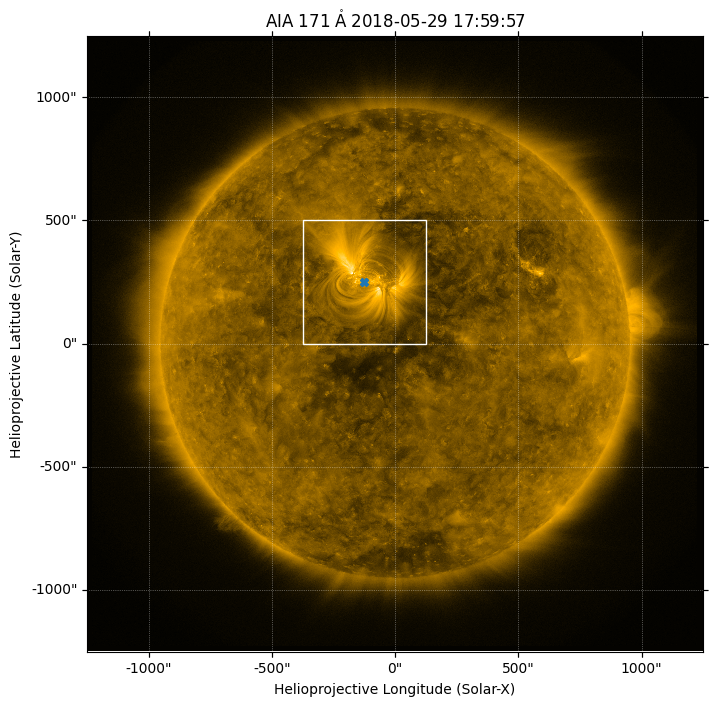

In [17]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection=ref_map_full_disk)
ref_map_full_disk.plot(axes=ax)
ref_map_full_disk.draw_quadrangle(bottom_left, width=fov[0], height=fov[1])
ax.plot_coord(ar_center, marker='X', color='C0')

Next, we want to create a cutout around the active region.
This will help us define our bounding box for the rest of our cutouts.

In [18]:
ref_map_cutout = ref_map_full_disk.submap(bottom_left, width=fov[0], height=fov[1])

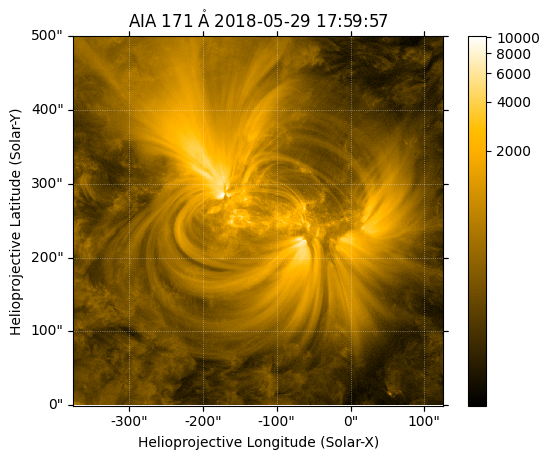

In [19]:
ref_map_cutout.peek()

In [20]:
bottom_left = ref_map_cutout.bottom_left_coord
top_right = ref_map_cutout.top_right_coord

## Create Dask Cluster

In [32]:
gateway = Gateway()

In [33]:
options = gateway.cluster_options()
options.worker_cores = 4
options.worker_memory = 8

In [34]:
cluster = gateway.new_cluster(options)

In [35]:
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/daskhub.16f10d21e4674fc9a679e0d08f517768/status,


In [36]:
pip_plugin = PipInstall(
    packages=[
        "ndcube",
        "sunpy[map]",
        "astropy",
    ],
    pip_options=["--upgrade"],
)
client.register_worker_plugin(pip_plugin)

{}

In [37]:
cluster.adapt(minimum=1, maximum=5)

## Cropping All Maps

Now that we've identified our region of interest, we can crop all of our maps at each timestep to this same field of view.

In [58]:
cutouts_171 = client.map(cutout_from_s3_file,
                         q[0]['URL'],
                         center=ar_center,
                         fov=fov,
                         fov_padding=[200,100]*u.arcsec)

In [59]:
time_171 = astropy.time.Time(client.gather(client.map(lambda x: x.date, cutouts_171)))
time_171 = (time_171 - time_start).to('s')

## Exposure Time Normalization

In [60]:
cutouts_171_normalized = client.map(lambda x: x/x.exposure_time, cutouts_171)

## Reprojecting Cutouts

In [83]:
cutouts_reprojected_171 = client.map(reproject_cutout, 
                                     cutouts_171_normalized,
                                     wcs_ref=ref_map_cutout.wcs,
                                     bottom_left=bottom_left,
                                     top_right=top_right)

In [84]:
is_nan = client.gather(
    client.map(lambda x: np.all(np.isnan(x.data)), cutouts_reprojected_171)
)

In [70]:
is_neg = client.gather(
    client.map(lambda x: np.any(x.data<0), cutouts_171)
)

In [71]:
np.where(is_neg)

(array([], dtype=int64),)

In [85]:
np.where(is_nan)

(array([], dtype=int64),)

In [94]:
foo = cutouts_reprojected_171[149].result()

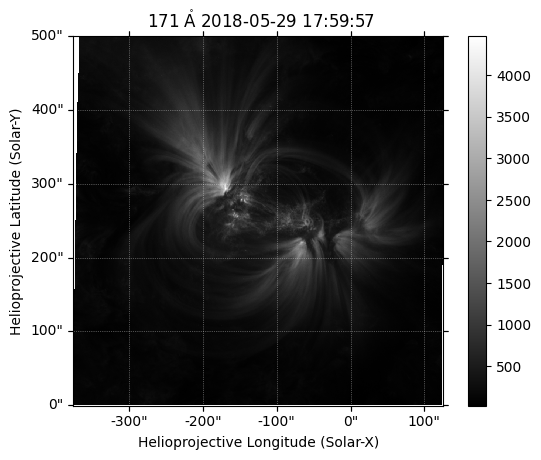

In [95]:
foo.peek()

## Stacking Images

- stack arrays
- interpolate
- build WCS with common (and uniform) time axis
- return resulting NDCube

In [86]:
cadence = 4*u.min
time_common = np.arange(0, (time_end - time_start).to_value('s'), cadence.to_value('s')) * u.s

Because each filter of the AIA telescope does not take an observation at exactly the same time, we need to interpolate each data cube corresponding each channel to a common time array.

In [87]:
cube_171 = stack_and_interpolate(cutouts_reprojected_171, time_171, time_common)

## Now do this for another channel...

In [33]:
file_list = search_registry(time_start, time_end, 193*u.angstrom)

In [88]:
q = Fido.search(
    a.Time(time_start, time_end),
    a.Wavelength(193*u.angstrom),
    heliocloud_attrs.Dataset('AIA'),
)

In [89]:
cutouts_193 = client.map(cutout_from_s3_file,
                         q[0]['URL'],
                         center=ar_center,
                         fov=fov,
                         fov_padding=[200,100]*u.arcsec)

In [90]:
time_193 = astropy.time.Time(client.gather(client.map(lambda x: x.date, cutouts_193)))
time_193 = (time_193 - time_start).to('s')

In [91]:
cutouts_193_normalized = client.map(lambda x: x/x.exposure_time, cutouts_193)

In [92]:
cutouts_reprojected_193 = client.map(reproject_cutout,
                                     cutouts_193_normalized,
                                     wcs_ref=ref_map_cutout.wcs,
                                     bottom_left=bottom_left,
                                     top_right=top_right)

In [93]:
cube_193 = stack_and_interpolate(cutouts_reprojected_193, time_193, time_common)

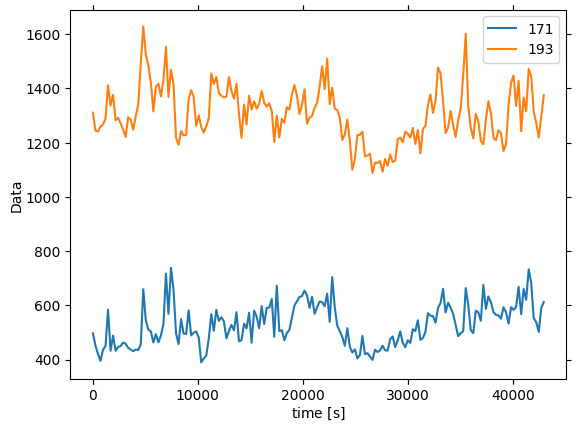

In [94]:
ax = cube_171[:,500,500].plot(label='171')
cube_193[:,500,500].plot(axes=ax, label='193')
ax.legend()

## Time Lag Analysis

Some details on what a time lag is here...

In [95]:
tl_193_171 = time_lag(cube_193.data, cube_171.data, time_common, [-6,6]*u.h)

Then visualize it

In [97]:
tl_map = ndcube.NDCube(tl_193_171, wcs=ref_map_cutout.wcs)

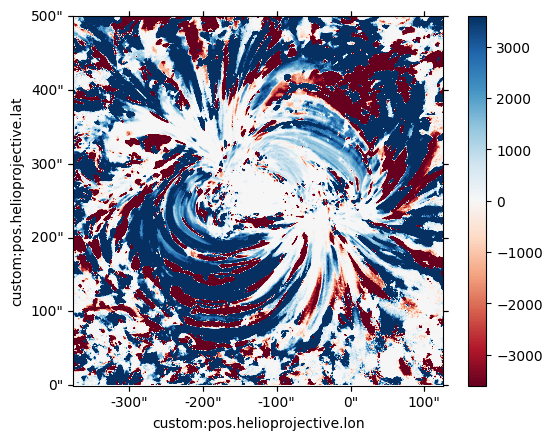

In [99]:
tl_map.plot(cmap='RdBu', vmin=-3600,vmax=3600)
plt.colorbar()

## Painpoints

- Subsetting does not work on compressed files
- There is not an easy way to map a FITS image array into a Dask array and leave the image array on disk
- We have to do a bunch of individual tasks on each map before stacking all the arrays into one cube
    - These individual operations are not "dask aware", e.g. reprojection
    - Necessitates this awkward interface between lower-level functions like `map,submit` and the much more powerful `dask.array` interface
- Incompatibility between xarray and WCS approaches to coordinates systems
- Incompatibility between astropy units and Dask

## Sandbox

In [26]:
def get_header(filename):
    with astropy.io.fits.open(filename, use_fsspec=True, fsspec_kwargs={'anon': True}) as hdul:
        header = hdul[1].header
    return header

def is_data_nan(filename):
    with astropy.io.fits.open(filename, use_fsspec=True, fsspec_kwargs={'anon': True}) as hdul:
        is_any_nan = np.any(np.isnan(hdul[1].data))
    return is_any_nan

In [16]:
all_headers = [get_header(f) for f in file_list['datakey']]

In [27]:
is_nan = [is_data_nan(f) for f in file_list['datakey']]

In [18]:
list(all_headers[0].keys())

['SIMPLE',
 'BITPIX',
 'NAXIS',
 'NAXIS1',
 'NAXIS2',
 'REQUESTI',
 'DATE',
 'TELESCOP',
 'INSTRUME',
 'WAVELNTH',
 'WAVEUNIT',
 'WAVE_STR',
 'CAMERA',
 'ORIGIN',
 'CONTENT',
 'FILENAME',
 'T_OBS',
 'T_REC',
 'DATE-OBS',
 'LICENSE',
 'PROC_LEV',
 'DATA_DOC',
 'IMG_TYPE',
 'SOURCE',
 'EXPTIME',
 'EXPSDEV',
 'INT_TIME',
 'FSN',
 'FID',
 'LVL_NUM',
 'QUALLEV0',
 'QUALITY',
 'CALVER32',
 'DEG_COR',
 'HISTORY',
 'COMMENT',
 'TOTVALS',
 'DATAVALS',
 'MISSVALS',
 'PERCENTD',
 'DATAMIN',
 'DATAMAX',
 'DATAMEDN',
 'DATAMEAN',
 'DATARMS',
 'DATASKEW',
 'DATAKURT',
 'OSCNMEAN',
 'OSCNRMS',
 'FLAT_REC',
 'CTYPE1',
 'CUNIT1',
 'CRVAL1',
 'CDELT1',
 'CRPIX1',
 'CTYPE2',
 'CUNIT2',
 'CRVAL2',
 'CDELT2',
 'CRPIX2',
 'CROTA2',
 'R_SUN',
 'MPO_REC',
 'INST_ROT',
 'IMSCL_MP',
 'X0_MP',
 'Y0_MP',
 'RSUN_LF',
 'X0_LF',
 'Y0_LF',
 'ASD_REC',
 'SAT_Y0',
 'SAT_Z0',
 'SAT_ROT',
 'ACS_MODE',
 'ACS_ECLP',
 'ACS_SUNP',
 'ACS_SAFE',
 'ACS_CGT',
 'ORB_REC',
 'DSUN_REF',
 'DSUN_OBS',
 'RSUN_REF',
 'RSUN_OBS',
 'GAEX

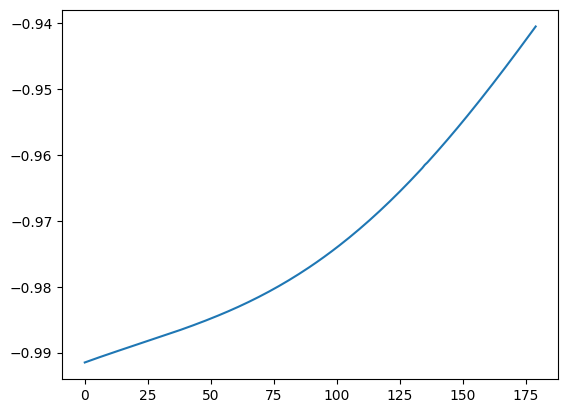

In [23]:
plt.plot([h['CRLT_OBS'] for h in all_headers])

In [73]:
problem_indices = [ 40,  85, 112, 142, 150, 163]

In [74]:
foo = map_from_s3_file(q[0]['URL'][problem_indices[1]])

In [75]:
foo_cutout = cutout_from_s3_file(q[0]['URL'][problem_indices[2]],
                                 ar_center,
                                 fov)

In [76]:
foo_cutout_repro = reproject_cutout(foo_cutout,
                                    ref_map_cutout.wcs,
                                    bottom_left,
                                    top_right)

Observatory,SDO/AIA
Instrument,AIA 3
Detector,
Measurement,171.0 Angstrom
Wavelength,171.0 Angstrom
Observation Date,2018-05-29 17:59:57
Exposure Time,2.000164 s
Dimension,[1002. 1002.] pix
Coordinate System,helioprojective
Scale,[0.00013889 0.00013889] deg / pix
Reference Pixel,[7.505e+02 5.000e-01] pix

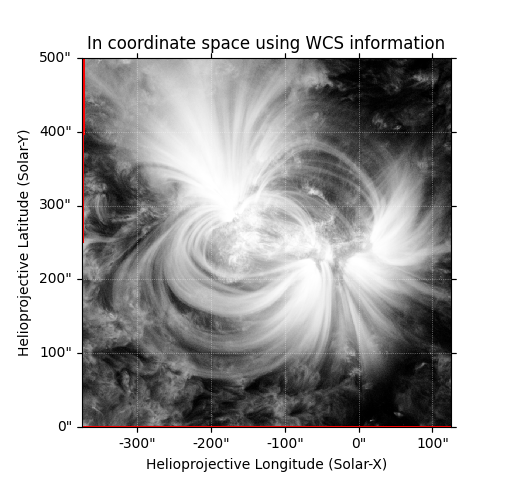
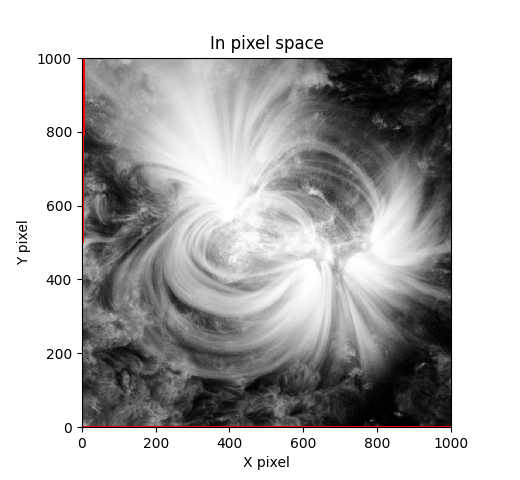
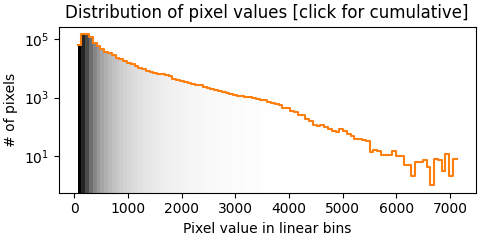
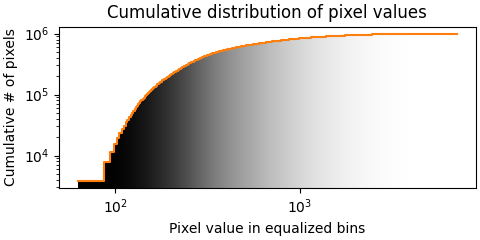

In [77]:
foo_cutout_repro

In [78]:
s_1 = client.submit(cutout_from_s3_file,
                    q[0]['URL'][problem_indices[1]],
                    center=ar_center,
                    fov=fov,
                    fov_padding=[200,100]*u.arcsec)

In [79]:
s_2 = client.submit(lambda x: x/x.exposure_time, s_1)

In [80]:
s_3 = client.submit(reproject_cutout, 
                    s_2,
                    wcs_ref=ref_map_cutout.wcs,
                    bottom_left=bottom_left,
                    top_right=top_right)

In [81]:
foo = s_3.result()

Observatory,SDO/AIA
Instrument,AIA 3
Detector,
Measurement,171.0 Angstrom
Wavelength,171.0 Angstrom
Observation Date,2018-05-29 17:59:57
Exposure Time,2.000159 s
Dimension,[1002. 1002.] pix
Coordinate System,helioprojective
Scale,[0.00013889 0.00013889] deg / pix
Reference Pixel,[7.505e+02 5.000e-01] pix

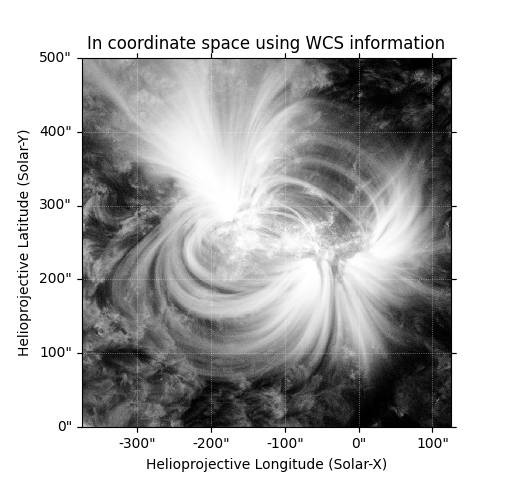
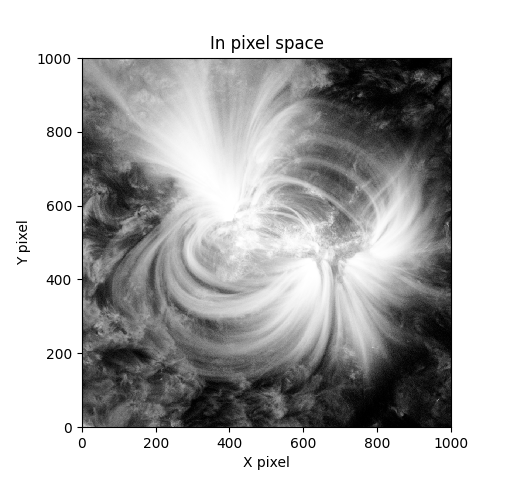
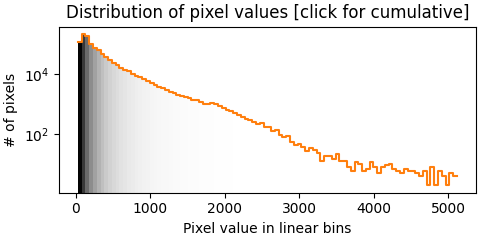
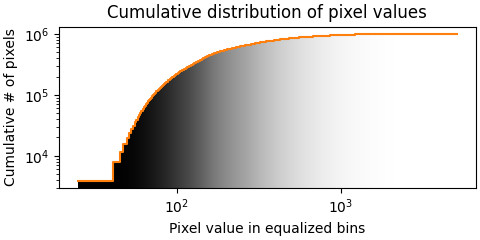

In [82]:
foo